# A Basic ARC Depletion Calculation
### *This notebook explores a basic depletion calculation for a compact FLiBe blanketed tokamak whose blanket has been doped with UF4*

### *Boilerplate*

In [19]:
import openmc
import openmc.deplete
import openmc.data as data
import numpy as np
import matplotlib.pyplot as plt

from simple_openmc_depletion import create_openmc_model
from extract_simple_depletion_results import plot_results

## Step 1: Setup the Transport Operator

In order to run a depletion simulation using OpenMC, it is necessary to initialize an object called an operator, which is used to run a transport simulation at a particular point in time when performig a depletion simulation. THis operator object can be though of as a wrapper around an OpenMC model object which allows it to be passed to an integrator object, which is then used to perform the depletion simulation. To do this we first need an OpenMC model which is properly configured. I have placed all of the OpenMC model setup code into a separate python file and placed it all into a function which allows me to expose the parameters that I want to adjust about the model and easily create many versions. This is the `create_openmc_model` function which takes in a percent of the blanket to be fertile material, as well as a DAGMC model. This is a little bit tricky because not any DAGMC model can be used, it has to be one which has the correct components with the correct names which correspond to the materials specified in the "simple_openmc_depletion.py" file. Nonetheless this was done to allow for multiple variations on the same model to be interchanged easily as tweaks to the geometry are made.

In [ ]:
#Open the DAGMC geometry of choice for the model to pass to the create_openmc_model function
dag_univ = openmc.DAGMCUniverse("dagmc.h5m")

#Use the create_openmc_model function to create a model with the desired geometry and fertile blanket percent
model = create_openmc_model(1, dag_univ, 10, 1000)

Next a chain file is needed, which provides the depletion solver with all of the necessary data about decay chains etc. to perform the calculation. The chain file used below is computed using a script in the OpenMC data repository which generates a chain file based on ENDFVII.1 data.

In [ ]:
#Open the chain file which contains all of the decay data needed for depletion simulations
chain_filename = 'chain_endfb71.xml'
chain = openmc.deplete.Chain.from_xml(chain_filename)

Now we package everything up into the operator object which we can pass to an integrator:

In [ ]:
#Use this model to create a transport operator for use in a depletion simulation
operator = openmc.deplete.Operator(model, chain_filename, normalization_mode='source-rate')

## Step 2: Setup and Run the Depletion Calculation

We need to specify a list of time steps at which to evaluate the transport operator and perform the simulation, as well as a list of the neutron source rates at that time step. For our purposes we take the source rate to be a constant, which assumes the ARC reactor is operating at full power continuously.

In [ ]:
#Set the timesteps and source rates to use for the depletion simulation
time_steps = [1000000*60*60] * 2
source_rates = [1.86e20]* 2

#Run the depletion simulation using a integration algorithm of choice
integrator = openmc.deplete.PredictorIntegrator(
    operator=operator, timesteps=time_steps, source_rates=source_rates, 
)

To run the depletion calculation we call the integrate function of the integrate object:

In [ ]:
integrator.integrate()

## Step 3: Plot the Results

matplotlib is used to visualize data extracted from the simulation. Data can be retrieved from two places: the `depletion_results.h5` file and from the individual statepoint files from each transport simulation. Its in these statepoint files that values from tallies setup in the OpenMC model can be extracted. Start by loading the depletion results file:

### Load data from the depletion results and individual statepoint files

In [13]:
#Load the results from the depletion simulation
results = openmc.deplete.ResultsList.from_hdf5("depletion_results.h5")

#This is just to get the list of times used in the simulation
times, _ = results.get_atoms("4", 'Pu239')
times = times /(365 * 24 * 60 * 60) #Convert to years

Extract data from individual statepoint files, specifically the TBR and total fission tallies:

In [31]:
#Extract fission and TBR values from statepoint files
tbr_std, tbr_vals, fis_std, fis_vals = np.empty(len(times)), np.empty(len(times)), np.empty(len(times)), np.empty(len(times))
for i in range(0, len(times)):
    sp = openmc.StatePoint(f'openmc_simulation_n{i}.h5')
    
    #Extract TBR values and std dev at each step in the simulation
    tbr_tally = sp.get_tally(name='tbr')
    tbr_vals[i] = tbr_tally.mean
    tbr_std[i] = tbr_tally.std_dev

    #Extract fission rates and std devs from each transport simulation
    fis_tally = sp.get_tally(name='fis')
    fis_vals[i] = fis_tally.mean
    fis_std[i] = fis_tally.std_dev

#Convert fission tally result to power in megawatts: total source rate (Hz) * energy per fission in MeV * joules/MeV * MW/W
fis_power = fis_vals * 1.86e20 * 200 * 1.602e-13 * 1e-6 

### Helper Functions
We can now define a few helper functions which will assist in extracting the data from the depletion results file:

In [11]:
#Converts number of atoms to kg of that isotope
def convert_to_kg(num_atoms, isotope):
    moles = num_atoms / (6.022e23) #divide by avogadro number to get in moles
    mass = (moles * data.atomic_mass(isotope))*0.001 #in kg (atmoic mass is molar mass in units of g/mol)
    return mass

#Retrieve the mass of a particular isotope in the blanket
def get_mass(isotope):
    _, atoms_in = results.get_atoms('4', isotope)
    _, atoms_out = results.get_atoms('5', isotope)

    mass = convert_to_kg(atoms_in + atoms_out, isotope)
    return mass

# Go from a fission rate to a fission power
def get_fis_power(isotope):
    _, fis_rate_in = results.get_reaction_rate("4", isotope, 'fission')
    _, fis_rate_out = results.get_reaction_rate("5", isotope, 'fission')
    power = (fis_rate_in + fis_rate_out) * 200 * 1.602e-13 * 1e-6 #Covert from rate to MW of power
    return power

### Plutonium Isotopic Composition in Time

Here we can plot how the population of various plutonium isotopes evolves in time. Obviously the most interesting isotope is 239 as this is the primary isotope used for weapons, but the other isotopes can interfere with the usefulness of the plutonium for weapons purposes and can determine the plutonium "grade"

First we create a list of plutonium isotopes we'd like to plot:

In [18]:
#List of plutonium isotopes whose masses will be plotted
plut_isotopes = ['Pu238', 'Pu239', 'Pu240', 'Pu241']

Then we iterate over this list and plot the mass of each isotope using the `get_mass` function:

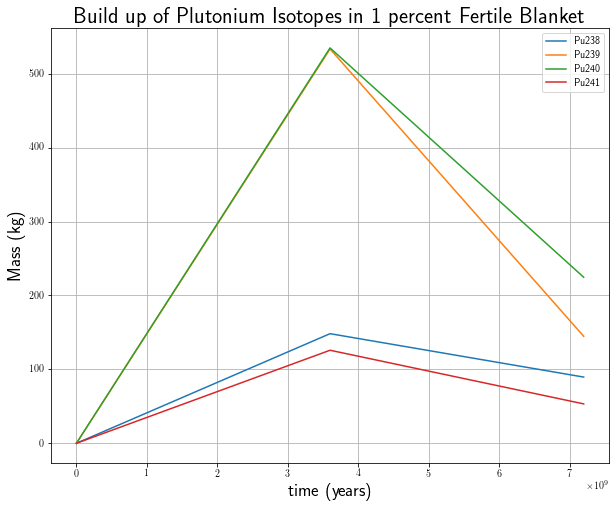

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

#Set matplotlib to use LaTeX
plt.rcParams['text.usetex'] = True

#Plot of Plutonium Mass
for iso in plut_isotopes:
    ax.plot(times, get_mass(iso), label=iso)

ax.set_title(r'Build up of Plutonium Isotopes in 1 percent Fertile Blanket', fontsize=22)
ax.set_ylabel(r'Mass (kg)', fontsize=18)
ax.set_xlabel(r'time (years)', fontsize=18)

ax.legend()
ax.grid()

Insert analysis about the above plot here. Not much to say at the moment.

### Fission Power

Plots of fission power in the blanket from various isotopes

Begin by specifying a list of isotopes whose fission power we would like to plot:

In [33]:
#List of fissile isotopes whose fission powers will be plotted
fis_isotopes = ['Pu239', 'Pu241', "U235", 'U238']

Iterate over this list and sequentially plot each one, using the `get_fis_power` function to compute the fission power of each isotope at each timestep.

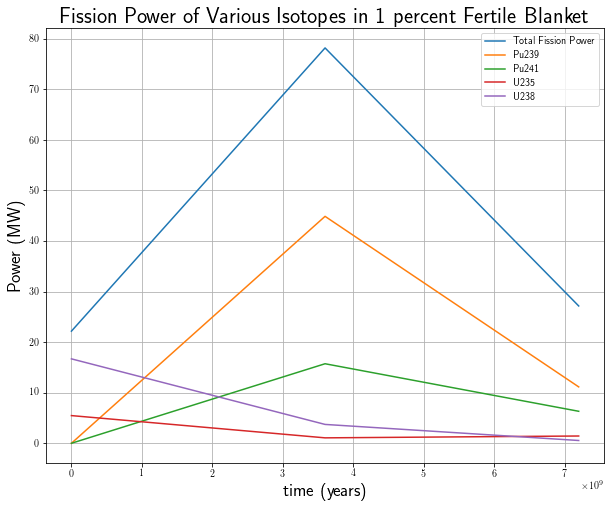

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

#Plot of fission power
ax.plot(times, fis_power, label='Total Fission Power')
for iso in fis_isotopes:
    ax.plot(times, get_fis_power(iso), label=iso)

ax.set_title(r'Fission Power of Various Isotopes in 1 percent Fertile Blanket', fontsize=22)
ax.set_ylabel(r'Power (MW)', fontsize=18)
ax.set_xlabel(r'time (years)', fontsize=18)

ax.legend()
ax.grid()